In [65]:
#https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python
import sys
!{sys.executable} -m pip install numpy pandas pmdarima statsmodels skforecast matplotlib seaborn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\threading.py:993: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  del self._target, self._args, self._kwargs
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\threading.py:993: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  del self._target, self._args, self._kwargs
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\threading.py:993: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  del self._target, self._args, self._kwargs


In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import contextlib
import re

import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

import warnings
warnings.filterwarnings('once')

In [73]:
data = fetch_dataset(name='fuel_consumption', raw=True)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha':'date', 'Gasolinas':'litters'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.loc[:'1990-01-01 00:00:00']
data = data.asfreq('MS')
data = data['litters']
display(data.head(4))

fuel_consumption
----------------
Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.
Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and
Corporación de Derecho Público tutelada por el Ministerio para la Transición
Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas
Shape of the dataset: (644, 6)


date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
Freq: MS, Name: litters, dtype: float64

Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


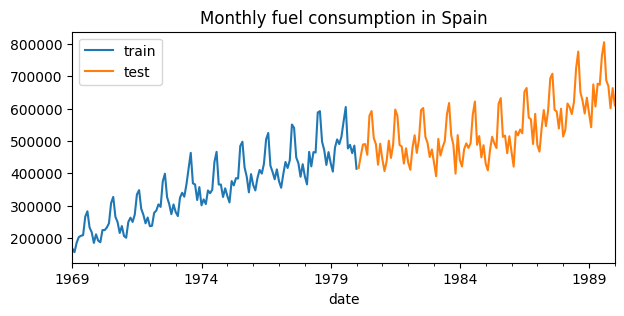

In [74]:
# Train-test dates
# ======================================================================================
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend()

Test stationarity for original series
-------------------------------------
ADF Statistic: -0.44612980998227797, p-value: 0.902107192394267
KPSS Statistic: 2.2096370946978383, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -3.6417276900323214, p-value: 0.005011605002137275
KPSS Statistic: 0.313271162357279, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -8.233942641655972, p-value: 5.959599575497111e-13
KPSS Statistic: 0.08065668267482215, p-value: 0.1


<Axes: title={'center': 'Differenced order 2'}, xlabel='date'>

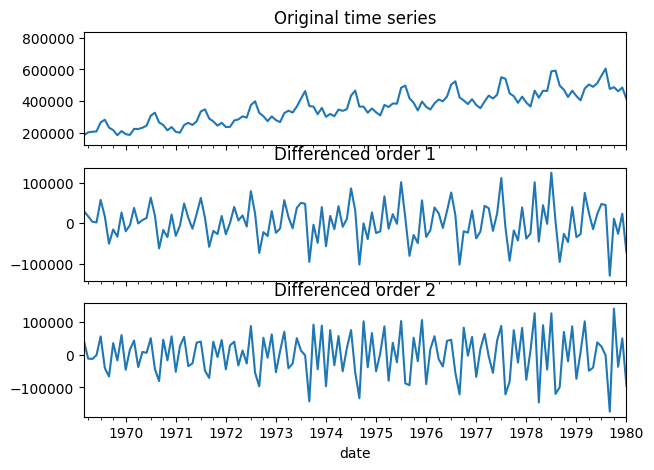

In [75]:
### Exploratory Analysis
# Test stationarity
# ==============================================================================
warnings.filterwarnings("ignore")

data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(data)
kpss_result = kpss(data)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(data.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(data.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2')

Text(0.5, 1.0, 'Autocorrelation differentiated series (order=1)')

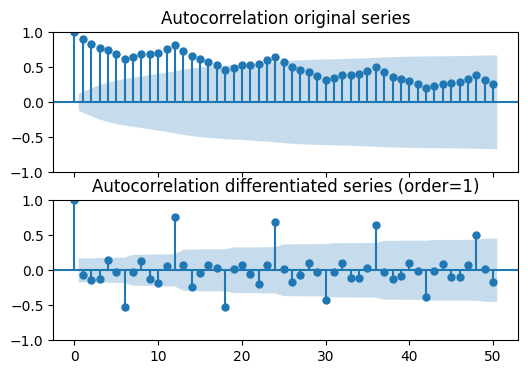

In [76]:
# Autocorrelation plot for original and differentiated series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differentiated series (order=1)')

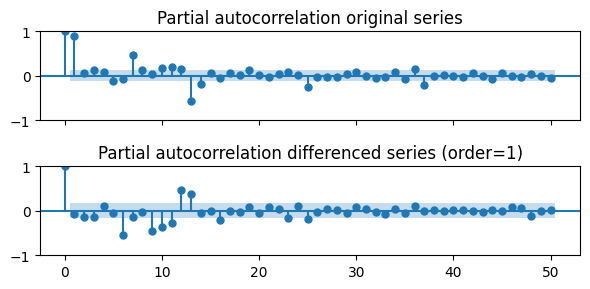

In [77]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)')
plt.tight_layout()

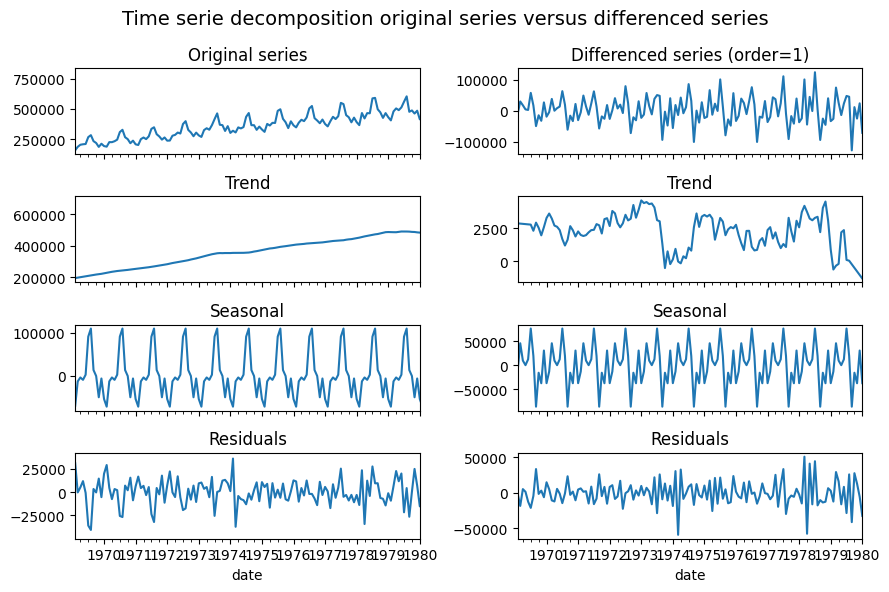

In [78]:
# Time series descoposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(data, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(data_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals', fontsize=12)
fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout()

In [79]:
# First-order differentiation combined with seasonal differentiation
# ==============================================================================
data_diff_1_12 = data_train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(data_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(data_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -4.387457230769955, p-value: 0.00031237732711269443
KPSS Statistic: 0.06291573421251052, p-value: 0.1


In [92]:
# ARIMA model with statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = SARIMAX(endog = data_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
model_res = model.fit(disp=0)
warnings.filterwarnings("default")
# model_res.summary()

predictions_statsmodels = model_res.get_forecast(steps=len(data_test)).predicted_mean
predictions_statsmodels.name = 'predictions_statsmodels'
# display(predictions_statsmodels.head(4))

In [94]:
# ARIMA model with skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model.fit(y=data_train)
model.summary()
warnings.filterwarnings("default")

predictions_skforecast = model.predict(steps=len(data_test))
predictions_skforecast.columns = ['skforecast']
# display(predictions_skforecast.head(4))

In [96]:
# ARIMA model with pdmarima.Sarimax
# ==============================================================================
model = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model.fit(y=data_train)
# model.summary()

predictions_pdmarima = model.predict(len(data_test))
predictions_pdmarima.name = 'predictions_pdmarima'
# display(predictions_pdmarima.head(4))

In [137]:
# Simple Exponential Smoothing (USAGE: when no trend and seasonality, real time and lack of data)
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = SimpleExpSmoothing(data_train, initialization_method="estimated")
model_res = model.fit(smoothing_level=0.4)
warnings.filterwarnings("default")

predictions_ses = model_res.forecast(len(data_test))
# display(predictions_ses.head(4))

In [138]:
# Double exponential smoothing, Holt's method (USAGE: when trend, consistent upward or downward trend)
model = Holt(data_train, initialization_method="estimated")
model_res = model.fit()

predictions_holt = model_res.forecast(len(data_test))

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [139]:
# Triple exponential smoothing, Holt-Winters method (USAGE: when trend and seasonality, with trends and repeating patterns)
model = ExponentialSmoothing(data_train, trend='add', seasonal='add')
model_res = model.fit()

predictions_holt_winters = model_res.forecast(len(data_test))

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [99]:
# VARMAX with statsmodels
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = VARMAX(endog=data_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
model_res = model.fit(disp=True)
warnings.filterwarnings("default")
# model_res.summary
predictions_statsmodels2 = model_res.get_forecast(steps=len(data_test)).predicted_mean
predictions_statsmodels2.name = 'predictions_statsmodels'
display(predictions_statsmodels.head(4))

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


IndexError: tuple index out of range

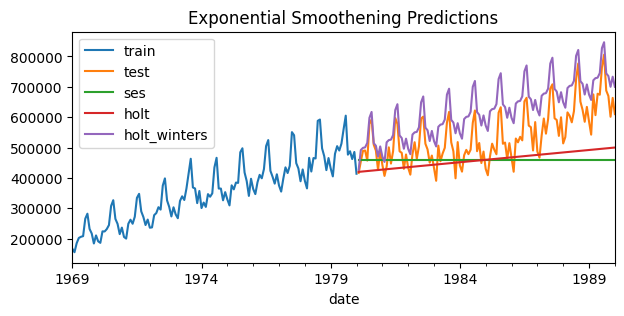

In [140]:
# Simple predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_ses.plot(ax=ax, label='ses')
predictions_holt.plot(ax=ax, label='holt')
predictions_holt_winters.plot(ax=ax, label='holt_winters')
ax.set_title('Exponential Smoothening Predictions')
ax.legend()

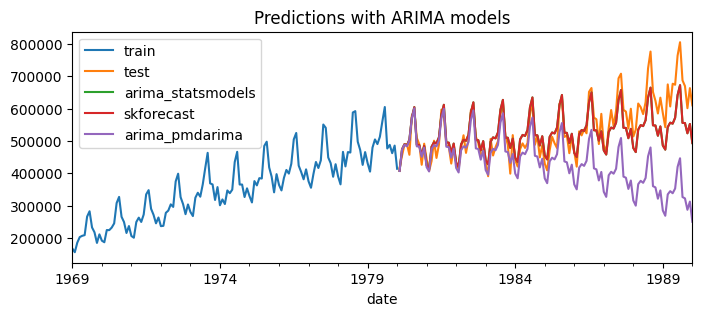

In [141]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_statsmodels.plot(ax=ax, label='arima_statsmodels')
predictions_skforecast.plot(ax=ax, label='arima_skforecast')
predictions_pdmarima.plot(ax=ax, label='arima_pmdarima')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [28]:
# ARIMA model with ForecasterSarimax and skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=data_train, suppress_warnings=True)

# Prediction
predictions = forecaster.predict(steps=len(data_test))
predictions.head(4)

1980-02-01    407504.056952
1980-03-01    473997.245816
1980-04-01    489983.091485
1980-05-01    485517.462872
Freq: MS, Name: pred, dtype: float64

In [29]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor = Sarimax(
                                order          = (1, 1, 1),
                                seasonal_order =(1, 1, 1, 12),
                                maxiter        = 200
                             )
             )
metric, predictions = backtesting_sarimax(
                          forecaster            = forecaster,
                          y                     = data,
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          steps                 = 12,
                          metric                = 'mean_absolute_error',
                          refit                 = True,
                          n_jobs                = "auto",
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )
display(metric)
predictions.head(4)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 10
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1981-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1981-01-01 00:00:00  (n=145)
    Validation: 1981-02-01 00:00:00 -- 1982-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1982-01-01 00:00:00  (n=157)
    Validation: 1982-02-01 00:00:00 -- 1983-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Valid

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py:580: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))
100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


,mean_absolute_error
0,19611.236348


,pred
1980-02-01,407504.056952
1980-03-01,473997.245816
1980-04-01,489983.091485
1980-05-01,485517.462872


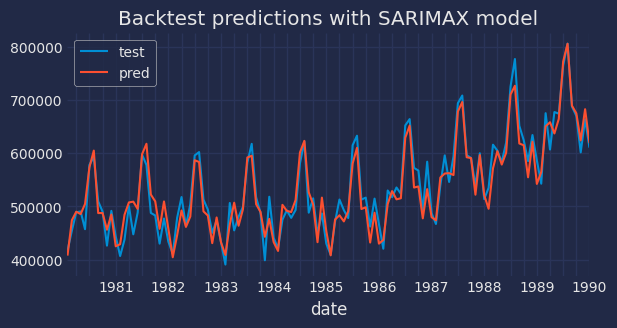

In [31]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax)
ax.set_title('Backtest predictions with SARIMAX model')
ax.legend()

Train dates      : 1969-01-01 00:00:00 --- 1976-01-01 00:00:00  (n=85)
Validation dates : 1976-02-01 00:00:00 --- 1984-01-01 00:00:00  (n=96)
Test dates       : 1984-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=72)


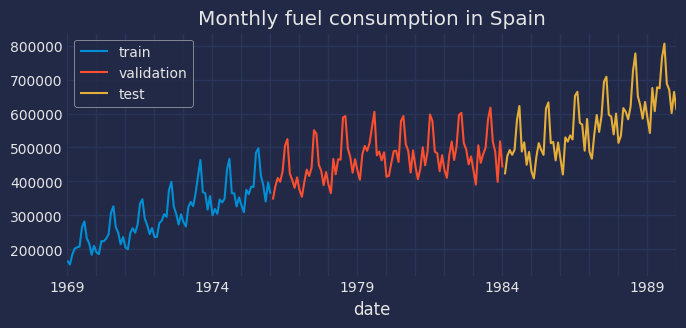

In [32]:
# Train-validation-test data
# ======================================================================================
end_train = '1976-01-01 23:59:59'
end_val = '1984-01-01 23:59:59'
print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  "
    f"(n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_val:])})"
)

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend()

In [33]:
# Grid search based on backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor = Sarimax(
                                order   = (1, 1, 1), # Placeholder replaced in the grid search
                                maxiter = 500
                             )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_val],
                   param_grid            = param_grid,
                   steps                 = 12,
                   refit                 = True,
                   metric                = 'mean_absolute_error',
                   initial_train_size    = len(data_train),
                   fixed_train_size      = False,
                   return_best           = False,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )
results_grid.head(5)

Number of models compared: 45.


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py:580: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))
params grid: 100%|██████████| 45/45 [00:45<00:00,  1.02s/it]


,params,mean_absolute_error,order,seasonal_order,trend
16,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897505,"(0, 1, 1)","(1, 1, 1, 12)",n
15,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897505,"(0, 1, 1)","(1, 1, 1, 12)",None
34,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376852,"(1, 1, 1)","(1, 1, 1, 12)",n
33,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376852,"(1, 1, 1)","(1, 1, 1, 12)",None
43,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",20176.728960,"(2, 1, 1)","(1, 1, 1, 12)",n


In [34]:
# Auto arima: selection based on AIC
# ==============================================================================
model = auto_arima(
            y                 = data.loc[:end_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # Seasonal period
            d                 = None, # The algorithm will determine 'd'
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3903.204, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3942.897, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3846.786, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3840.318, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3873.797, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3841.882, Time=0.48 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3841.572, Time=1.86 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3852.231, Time=0.29 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3842.593, Time=2.72 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3904.615, Time=0.18 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3834.135, Time=0.47 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3866.187, Time=0.12 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3835.564, Time=0.45 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3835.160, Time=2.03 sec
 ARIMA(1,1,1)(1,1,0

In [41]:
# Capture auto_arima trace in a pandas dataframe
# ==============================================================================
buffer = StringIO()
with contextlib.redirect_stdout(buffer):
    auto_arima(
            y                 = data.loc[:end_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12,   # Seasonal period
            d                 = None, # The algorithm will determine 'd'
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )
trace_autoarima = buffer.getvalue()
pattern = r"ARIMA\((\d+),(\d+),(\d+)\)\((\d+),(\d+),(\d+)\)\[(\d+)\]\s+(intercept)?\s+:\s+AIC=([\d\.]+), Time=([\d\.]+) sec"
matches = re.findall(pattern, trace_autoarima)
results = pd.DataFrame(
    matches, columns=["p", "d", "q", "P", "D", "Q", "m", "intercept", "AIC", "Time"]
)
results["order"] = results[["p", "d", "q"]].apply(
    lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]})", axis=1
)
results["seasonal_order"] = results[["P", "D", "Q", "m"]].apply(
    lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]},{x.iloc[3]})", axis=1
)
results = results[["order", "seasonal_order", "intercept", "AIC", "Time"]]
results.sort_values(by="AIC").reset_index(drop=True)

,order,seasonal_order,intercept,AIC,Time
0,"(1,1,1)","(0,1,1,12)",,3834.135,0.47
1,"(2,1,0)","(0,1,1,12)",,3834.277,0.43
2,"(0,1,2)","(0,1,1,12)",,3834.320,0.40
3,"(1,1,1)","(0,1,2,12)",,3835.160,1.82
4,"(1,1,1)","(0,1,1,12)",intercept,3835.455,0.54
5,"(1,1,1)","(1,1,1,12)",,3835.564,0.45
6,"(2,1,1)","(0,1,1,12)",,3836.104,1.13
7,"(1,1,2)","(0,1,1,12)",,3836.107,0.67
8,"(1,1,1)","(1,1,2,12)",,3836.443,3.11
9,"(1,1,0)","(0,1,1,12)",,3836.696,0.31


In [42]:
# Backtest predictions with the best model according to grid search
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )

metric_m1, predictions_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = data,
                                initial_train_size    = len(data.loc[:end_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

# Backtest predictions with the best model according to auto-arima
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), maxiter=500),
             )

metric_m2, predictions_m2 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = data,
                                initial_train_size    = len(data.loc[:end_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py:580: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))
100%|██████████| 6/6 [00:03<00:00,  1.81it/s]
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py:580: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))
100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Metric (mean_absolute_error) for grid search model:


,mean_absolute_error
0,19803.080728


Metric (mean_absolute_error) for auto arima-model:


,mean_absolute_error
0,20149.352199


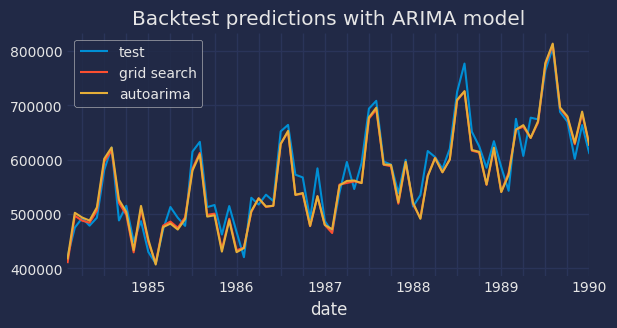

In [43]:
# Compare predictions
# ==============================================================================
print("Metric (mean_absolute_error) for grid search model:")
display(metric_m1)
print("Metric (mean_absolute_error) for auto arima-model:")
display(metric_m2)

fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_val:].plot(ax=ax, label='test')
predictions_m1 = predictions_m1.rename(columns={'pred': 'grid search'})
predictions_m2 = predictions_m2.rename(columns={'pred': 'autoarima'})
predictions_m1.plot(ax=ax)
predictions_m2.plot(ax=ax)
ax.set_title('Backtest predictions with ARIMA model')
ax.legend()

Train dates       : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Last window dates : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


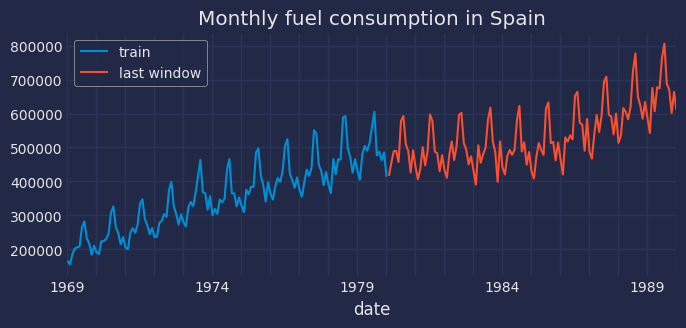

In [44]:
# Split data Train - Last window
# ==============================================================================
end_train = '1980-01-01 23:59:59'                       
print(
    f"Train dates       : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Last window dates : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='last window')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend()

In [45]:
# Train ARIMA forecaster with values from 1969-01-01 to 1980-01-01
# ==============================================================================
forecaster = ForecasterSarimax(
                regressor = Sarimax(
                    order          = (0, 1, 1),
                    seasonal_order = (1, 1, 1, 12),
                    maxiter        = 500
                )
)
forecaster.fit(y=data.loc[:end_train])

In [46]:
# Predict using last window
# ==============================================================================
predictions = forecaster.predict(
                  steps       = 12,
                  last_window = data.loc[end_train:]
              )
predictions.head(3)

1990-02-01    580893.320808
1990-03-01    693624.449209
1990-04-01    654315.472044
Freq: MS, Name: pred, dtype: float64